# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [4]:
# Import relevant modules to project
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import dataframe_image as dfi
%matplotlib inline

# Part 1 - Exploratory Data Analysis (EDA)

In [5]:
'''
Offers Data Exploration
'''

# Read in portfolio data set and display data
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
# First step is to create dummy variables for the channels column and unpack the column of lists into respective columns of 1's and 0's
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
channel_dummies

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [7]:
# Rejoin dummy variables from channels into portfolio and drop original channels column
portfolio = portfolio.join(other = channel_dummies)
portfolio.drop(columns = ['channels'], inplace = True)

In [8]:
# Create dummy variables for the offer_type column
offer_type_dummies = pd.get_dummies(portfolio['offer_type'])
offer_type_dummies

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [9]:
# Merge offer_type_dummies to portfolio dataframe, but keep the original offer_type column for heuristics
portfolio_cleaned = portfolio.join(other = offer_type_dummies)

# Rename id to offer and set as index
portfolio_cleaned.rename(columns = {'id': 'offer'}, inplace = True)

In [10]:
portfolio_cleaned

,reward,difficulty,duration,offer_type,offer,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [11]:
'''
Customer Data Exploration
'''

# Read in customer data set
profile = pd.read_json('profile.json', orient='records', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
# Find the length of the dataframe
profile.shape[0]

17000

In [13]:
# Find the percentage of null values per column in profile dataframe
profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [14]:
# Find if there are duplicate people in the data set
profile['id'].duplicated().sum()

0

In [15]:
# Rename ID to customer and set index to customer
profile.rename(columns={'id': 'customer'}, inplace = True)
profile.head()

,gender,age,customer,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [16]:
# Something looks funny with customers of age 118, NaN income, and no gender. Diving further into a filtered subset of the df:
strange_customers = profile[(profile['age'] == 118) & (profile['income'].isnull() == True) & (profile['gender'].isnull() == True)]
strange_customers_sub = strange_customers.iloc[:5]
dfi.export(strange_customers_sub, 'strange_customers.png')

In [17]:
len(strange_customers)

2175

In [18]:
len(profile)

17000

In [19]:
len(strange_customers)/len(profile)

0.12794117647058822

In [20]:
# Since any heuristics or machine learning models will be inaccurately skewed by these 'strange customers', 
    # I will need to drop them from the dataset by selecting the subset that does not contain them

# I will later drop 'strange customers' in final merged data frame
    
# profile_cleaned = profile[(profile['age'] != 118) & (profile['income'].isnull() == False) & (profile['gender'].isnull() == False)]
# profile_cleaned.shape[0]

In [24]:
'''
Transcript Data Analysis
'''

# Read in transcript data set
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [25]:
# Find number of rows in transcript dataframe
transcript.shape[0]

306534

In [26]:
# See the data
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
# Find amount of null values by column
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [28]:
# Red comments below describe interpretation of transcript dataframe
'''
Dataframe is similar to a logging console:
- Transaction = any time purchase made (transaction is dumb in that it does not factor in offers)
- Offer Recieved = offer sent to customer, but customer may not have viewed
- Offer Viewed = Offer that was sent and viewed by customer
- Offer Completed = Offer completed by customer, but customer may not have viewed the offer
'''

# Finding the types of events in this 'logging' console
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [29]:
# Visualize dataframe
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [30]:
# Going to start by figuring out more about the value column of dictionaries by starting with transaction type
transcript[transcript['event'] == 'transaction']

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [31]:
value_image = transcript[transcript['event'] == 'transaction'][['event','value']].iloc[:5]
dfi.export(value_image,'value_col_1.png')

In [32]:
value_image2 = transcript[transcript['event'] == 'offer received'][['event','value']].iloc[:5]
dfi.export(value_image2,'value_col_2.png')

In [33]:
# Create 2 new columns, 1 for dictionary key and the other for dictionary value. Dictionary in json format as well so I will use json_normalize() method to unpack
value_df = pd.json_normalize(transcript['value'])

In [34]:
# Confirm number of rows of created dataframe is consistent with original transcript dataframe
value_df.shape[0]

306534

In [35]:
# See the unpacking
value_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [36]:
# Drop NaN values in both offer id and offer_id columns since they are both referring to the same offer id and need to be merged
value_df['offer_id'].fillna("", inplace = True)
value_df['offer id'].fillna("", inplace = True)

# Merge the offer_id and offer id columns since they are referring to the singular column in the portfolio dataset
value_df['offer'] = value_df['offer id'] + value_df['offer_id']

# Fill empty strings in offer with NaN values
value_df['offer'].replace("", np.nan, inplace = True)

# Drop the original offer id and offer_id columns
value_df.drop(columns = ['offer id', 'offer_id'], inplace = True)

In [37]:
value_df.head()

,amount,reward,offer
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [38]:
# Need to confirm if reward and amount are separate entities
value_df[value_df['reward'].isnull() == False]
# Based on below yes they are different. Amount is customer spending and reward is starbucks paying customer credit for completing an offer

,amount,reward,offer
12658,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
12672,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4
12679,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd
12697,NaN,10.0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...
306475,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2
306497,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4
306509,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4


In [39]:
# Rename reward for clarification
value_df.rename(columns = {'reward': 'reward_received'}, inplace = True)

In [40]:
# Remerge unpacked dictionary value to df and then drop original value column
transcript_cleaned = pd.concat([transcript,value_df], axis = 1)
transcript_cleaned.drop(columns = ['value'], inplace = True)
transcript_cleaned

,person,event,time,amount,reward_received,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN


In [41]:
# Confirm rows retained
transcript_cleaned.shape[0]

306534

# Part 2: Merging 3 Dataframes

In [42]:
# To start I will merge transcript_cleaned and profile (I will remove strange customers after merging all 3 datasets)

# Need to use merge to join transcript_cleaned and profile due to row # difference 
df1 = pd.merge(left = transcript_cleaned, right = profile, how = 'left', left_on = 'person', right_on = 'customer')

In [43]:
# Ensure rows preserved
df1.shape[0]

306534

In [44]:
# Visualize
df1.head()

,person,event,time,amount,reward_received,offer,gender,age,customer,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [45]:
# Now I can drop customer column since it is a duplicate to the person column
df1.drop(columns = ['customer'], inplace = True)

In [46]:
# Now I can merge df1 and portfolio_cleaned using merge due to row # difference
df = pd.merge(left = df1, right = portfolio_cleaned, how = 'left', left_on = 'offer', right_on = 'offer')

In [47]:
# Visualize
df.head()

,person,event,time,amount,reward_received,offer,gender,age,became_member_on,income,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN,...,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,...,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN,...,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN,...,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [48]:
# Check columns present
df.columns

Index(['person', 'event', 'time', 'amount', 'reward_received', 'offer',
       'gender', 'age', 'became_member_on', 'income', 'reward', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational'],
      dtype='object')

In [49]:
# Drop the reward column since it is tied to the lookup dataframe portfolio and not a reward the customer recieved. If a customer completed the offer, the reward_received should be the same
df.drop(columns = ['reward'], inplace = True)

In [50]:
# Get dummies for event column using np.where function
df['transaction'] = np.where(df['event'].str.contains('transaction'), 1, 0)

In [51]:
df['offer_received'] = np.where(df['event'].str.contains('received'), 1, 0)

In [52]:
df['offer_viewed'] = np.where(df['event'].str.contains('viewed'), 1, 0)

In [53]:
df['offer_completed'] = np.where(df['event'].str.contains('completed'), 1, 0)

In [54]:
# Number of columns exploding fast so need to set options and display max columns
pd.set_option('display.max_columns', None)
df.head()

,person,event,time,amount,reward_received,offer,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,transaction,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0


In [55]:
# Now I will drop 'strange customers' identified previously in profile dataset
df = df[(df['age'] != 118) & (df['income'].isnull() == False) & (df['gender'].isnull() == False)]

In [56]:
# Ensure rows filtered to exclude strange customers
df.shape[0]

272762

In [57]:
# Final combined data set
df.head()

,person,event,time,amount,reward_received,offer,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,transaction,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,M,65,20180209,53000.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,58,20171111,51000.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,61,20170911,57000.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0


# Step 3: Explore Merged Dataframe to Answer Some Questions

In [58]:
# Find unique amount of customers
df['person'].nunique()

14825

In [107]:
# Question 1: Does income and age play a factor in the type of offer customers complete (whether or not they viewed)?
df_q1 = df.loc[0::,['offer_type','income','offer_completed','age','gender','offer']]
df_q1 = df_q1[df_q1['offer_completed'] == 1]

# Clean O gender type to Unkown
df_q1['gender'].replace('O', 'Unknown', inplace = True)

df_q1_1 = df_q1.groupby(['offer_type','gender']).mean()[['income','age']]
# Income and age difference negligible based on below
dfi.export(df_q1_1, 'dataframe_q1.png')

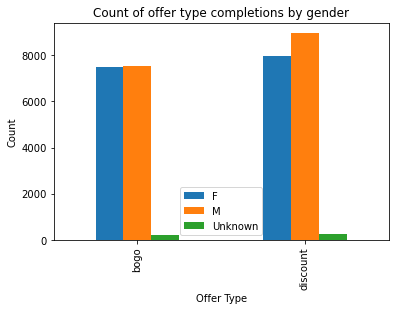

In [111]:
# Question 2: How does gender influence offer types that are completed?
df_q2 = df.loc[0::,['offer_type','gender','event','offer']]
df_q2 = df_q2[(df_q2['event'] == 'offer completed')]

# Clean O gender type to Unkown
df_q2['gender'].replace('O', 'Unknown', inplace = True)

# Get dummies for gender
gender_dummies = pd.get_dummies(df_q2['gender'])

# Concatenate dummies to get a count in groupby of offers completed by type by gender
df_gender = pd.concat([df_q2,gender_dummies], axis = 1)
df_gender.groupby(['offer_type'])[['F','M','Unknown']].sum().plot(kind = 'bar');
plt.ylabel('Count');
plt.xlabel('Offer Type');
plt.title('Count of offer type completions by gender');
plt.savefig('gender_offertype.png', dpi=300, bbox_inches='tight')

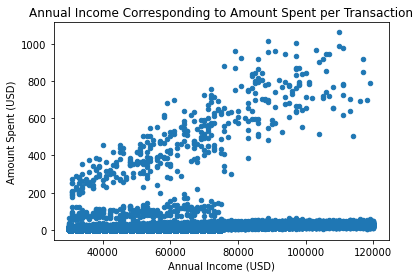

In [61]:
# Question 3: Does income play a factor in how much people spend in transactions (Offers irrelevent)?
df_q3 = df.loc[0::,['amount','income','event']]
df_q3 = df_q3[df_q3['event'] == 'transaction']
df_q3.plot(['income'],['amount'],kind = 'scatter');
plt.ylabel('Amount Spent (USD)');
plt.xlabel('Annual Income (USD)');
plt.title('Annual Income Corresponding to Amount Spent per Transaction');
plt.savefig('coffee_money.png', dpi=300, bbox_inches='tight')

In [62]:
# Looks like a possible trend, but how many people spend over $50 per transaction regardless of income?
high_rollers = df_q3[df_q3['amount'] >= 50].shape[0]
print(f'The amount of people that spend greater than or equal to $50 per transaction: {high_rollers}')

The amount of people that spend greater than or equal to $50 per transaction: 642


In [63]:
# How many people spend less than $50 per transaction
common_folk = df_q3[df_q3['amount'] < 50].shape[0]
common_spenders = (common_folk/df_q3.shape[0])
common_spenders
#print(f'The amount of people that spend less than $100 per transaction: {common_folk}')

0.9948207846269271

In [64]:
# Find percentage of people that are high_rollers (>$50 per transaction)
big_spenders = (high_rollers/df_q3.shape[0])
print(f'The percentage of people that spend over $50 per transaction are {big_spenders}% of all people')

The percentage of people that spend over $50 per transaction are 0.005179215373072921% of all people


In [65]:
# Based on above 3 cells the percentage of people that spend over $100 is extremely low, and to extract a linear trend from the scatter plot above would be highly difficult due
    # to highly flat (or r^2 = 0) shape of the spread of data

In [66]:
# What is the average amount that people spend at Starbucks?
avg_spent = df_q3['amount'].mean()
print(f'The average spent per transaction: ${avg_spent}')

The average spent per transaction: $13.996324531893954


In [67]:
# Question 4: Does difficulty (required spending amount of offer) attract different age or income groups?
df_q4 = df.loc[0::,['age','difficulty','gender','income','event']]
df_q4 = df_q4[df_q4['event'] == 'offer completed']
df_q4.groupby(['difficulty']).mean()[['age','income']]

,age,income
difficulty,,
5.0,55.508986,68423.712459
7.0,54.846500,66925.092100
10.0,56.114665,70206.095334
20.0,56.667750,71876.255168


In [68]:
# Question 8: Do Channels influence offer completed?
df_q8 = df.loc[0::,['age','gender','income','offer','offer_completed','email','mobile','social','web']]

df_q8.groupby(['offer']).sum()[['offer_completed','email','mobile','social','web']]

,offer_completed,email,mobile,social,web
offer,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3386,12327.0,0.0,0.0,12327.0
2298d6c36e964ae4a3e7e9706d1fb8c2,4886,17920.0,17920.0,17920.0,17920.0
2906b810c7d4411798c6938adc9daaa5,3911,14002.0,14002.0,0.0,14002.0
3f207df678b143eea3cee63160fa8bed,0,10144.0,10144.0,0.0,10144.0
4d5c57ea9a6940dd891ad53e9dbe8da0,3310,16232.0,16232.0,16232.0,16232.0
5a8bc65990b245e5a138643cd4eb9837,0,12516.0,12516.0,12516.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,4188,14372.0,14372.0,0.0,14372.0
ae264e3637204a6fb9bb56bc8210ddfd,3657,16241.0,16241.0,16241.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,4103,16989.0,16989.0,16989.0,16989.0


In [69]:
# Question 5: Which groups complete an offer without viewing it?

# Find 2 1d arrays of people that have either viewed an offer or completed an offer below
people_completed = df[df['offer_completed'] == 1]['person'].values
people_viewed = df[df['offer_viewed'] == 1]['person'].values

# Iterate through people who have completed offers that are not in offers viewed
people_noview = [person for person in people_completed if person not in people_viewed]

In [70]:
# Create a series of the list generated
people_noview_series = pd.Series(people_noview, name = 'person')

In [71]:
# Find how many unique people are in the list
people_noview_series.nunique()

70

In [72]:
# Find the total amount of people in the list
people_noview_series.shape[0]

109

In [73]:
# Remove duplicate values of same people
people_noview_series.drop_duplicates(keep = 'first', inplace = True)

In [74]:
# Confirm duplicates dropped
len(people_noview_series)

70

In [75]:
# Find total unique people in merged dataframe:
df['person'].nunique()

14825

In [76]:
# Find population of people who complete offers without viewing
noviews_size = len(people_noview_series)/df['person'].nunique()
noviews_size

0.004721753794266442

In [77]:
# Now I can filter original dataframe by merging
df_noview = pd.merge(left = people_noview_series, right = df, how = 'left', left_on = 'person', right_on = 'person')

# Confirm offers have not been viewed
df_noview['offer_viewed'].value_counts()

0    659
Name: offer_viewed, dtype: int64

In [78]:
# View offer types
df_noview['offer_type'].value_counts()

discount         181
bogo             115
informational     51
Name: offer_type, dtype: int64

In [79]:
df_noview.head()

,person,event,time,amount,reward_received,offer,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,transaction,offer_received,offer_viewed,offer_completed
0,b860d355ef6e4c66b5d5a837c56ef32d,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,49,20171226,110000.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1,0,0
1,b860d355ef6e4c66b5d5a837c56ef32d,transaction,0,38.38,NaN,NaN,F,49,20171226,110000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2,b860d355ef6e4c66b5d5a837c56ef32d,offer completed,0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,49,20171226,110000.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0,0,1
3,b860d355ef6e4c66b5d5a837c56ef32d,transaction,48,39.68,NaN,NaN,F,49,20171226,110000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
4,b860d355ef6e4c66b5d5a837c56ef32d,offer received,168,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,F,49,20171226,110000.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0


In [80]:
# Now I need to significantly clean df_noview since it has a logging format similar to transcript with duplicates and irrelevant information

# Filter to offers completed and check length
df_noview = df_noview[df_noview['offer_completed'] == 1]
df_noview.shape[0]

109

In [81]:
# Check for nans
df_noview.isnull().mean()

person              0.0
event               0.0
time                0.0
amount              1.0
reward_received     0.0
offer               0.0
gender              0.0
age                 0.0
became_member_on    0.0
income              0.0
difficulty          0.0
duration            0.0
offer_type          0.0
email               0.0
mobile              0.0
social              0.0
web                 0.0
bogo                0.0
discount            0.0
informational       0.0
transaction         0.0
offer_received      0.0
offer_viewed        0.0
offer_completed     0.0
dtype: float64

In [82]:
# Breakdown by demographics
# Question 6: Does income, and age by gender type play a factor in the type of offer customers complete (when NOT VIEWED)?
df_q6 = df_noview.loc[0::,['offer_type','income','age','difficulty','gender']]
df_q6_group = df_q6.groupby(['offer_type','gender']).mean()[['income','age']]
dfi.export(df_q6_group, 'dataframe_q6.png')

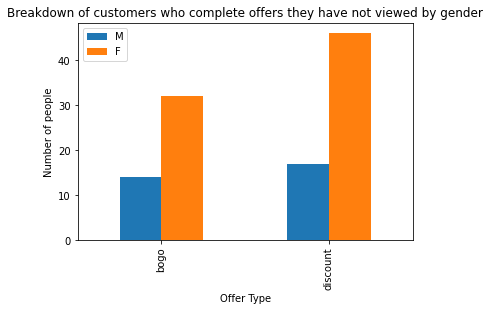

In [83]:
# Question 7: How does gender influence offer types that are completed (when NOT VIEWED)?
df_q7 = df_noview.loc[0::,['offer_type','gender']]

# Clean O gender type to Unkown
df_q7['gender'].replace('O', 'Unknown', inplace = True)

# Get dummies for gender
gender_dum = pd.get_dummies(df_q7['gender'])

# Concatenate dummies to get a count in groupby of offers completed by type by gender
df_gen = pd.concat([df_q7,gender_dum], axis = 1)
df_gen.groupby(['offer_type'])[['M','F']].sum().plot(kind = 'bar');
plt.ylabel('Number of people');
plt.xlabel('Offer Type');
plt.title('Breakdown of customers who complete offers they have not viewed by gender');
plt.savefig('noviews.png', dpi=300, bbox_inches='tight')

In [84]:
# Seems like women are much more likely to complete offers without viewing them than men are
df_gen.groupby(['offer_type'])[['F','M']].sum()

,F,M
offer_type,,
bogo,32,14
discount,46,17


# Simple Linear Regression Machine Learning Model

In [85]:
'''
Model seeks to predict amount spent per transaction based on customer age, income, and gender.
'''

'\nModel seeks to predict amount spent per transaction based on customer age, income, and gender.\n'

In [86]:
# Check df
df.head()

,person,event,time,amount,reward_received,offer,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,transaction,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,M,65,20180209,53000.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,58,20171111,51000.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,61,20170911,57000.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0


In [87]:
# Predict amount someone will spend given income, age, and gender
df_ml = df[['amount','gender','age','income','transaction']]
df_ml.head()

,amount,gender,age,income,transaction
0,NaN,F,75,100000.0,0
2,NaN,M,68,70000.0,0
5,NaN,M,65,53000.0,0
7,NaN,M,58,51000.0,0
8,NaN,F,61,57000.0,0


In [88]:
# Pre-processing steps (drop O gender type and filter for transaction events
df_ml = df_ml[(df_ml['transaction'] == 1) & (df_ml['gender'] != 'O')]
df_ml['gender'].value_counts()

M    72794
F    49382
Name: gender, dtype: int64

In [89]:
# Check for NaN values
df_ml.isnull().mean()

amount         0.0
gender         0.0
age            0.0
income         0.0
transaction    0.0
dtype: float64

In [90]:
# Dummy variables for gender
gender_dummies = pd.get_dummies(df_ml['gender'])
df_ml = pd.concat([df_ml,gender_dummies], axis = 1)
df_ml.drop(columns=['gender','transaction'], inplace = True)

In [91]:
df_ml.head()

,amount,age,income,F,M
12654,0.83,20,30000.0,1,0
12657,34.56,42,96000.0,0,1
12659,13.23,36,56000.0,0,1
12670,19.51,55,94000.0,1,0
12671,18.97,39,67000.0,1,0


In [92]:
# For write up please disregard
dfi.export(df_ml.iloc[:5],'df_ml.png')

In [93]:
# No normalization or standardization step before refining

# Create matrix of input variables and define response variable
input_variables = df_ml.drop('amount', axis=1)
target = df_ml['amount']
X = input_variables
y = target

# Split the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Four steps:

#Instantiate
lm_model_dumb = LinearRegression(normalize=True) 

#Fit
lm_model_dumb.fit(X_train, y_train) 

#Predict and Score the model
y_test_preds = lm_model_dumb.predict(X_test) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model was 0.05879398428498239 on 36653 values.'

In [94]:
# Preparing ML Model (Normalization approach)

# Create matrix of input variables and define response variable
input_variables = df_ml.drop('amount', axis=1)
target = df_ml['amount']
X = input_variables
y = target

# Split the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


# Normalize data using sklearn

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train_norm, y_train) 

#Predict and Score the model
y_test_preds = lm_model.predict(X_test_norm) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model was 0.05879398428498239 on 36653 values.'

In [95]:
# Preparing ML Model (Scalarization approach)
from sklearn.preprocessing import StandardScaler

# Copy training and testing datasets from split above
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# Numerical features
numerical_cols = ['age','income']

# Apply standardization on numerical features
for i in numerical_cols:
    
    # Fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # Transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # Transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])
    
#Instantiate
lm_model2 = LinearRegression(normalize=True) 

#Fit
lm_model2.fit(X_train_stand, y_train) 

#Predict and Score the model
y_test_preds = lm_model2.predict(X_test_stand) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model was 0.05879398428498239 on 36653 values.'

In [133]:
df['offer'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    18062
2298d6c36e964ae4a3e7e9706d1fb8c2    17920
f19421c1d4aa40978ebb69ca19b0e20d    16989
ae264e3637204a6fb9bb56bc8210ddfd    16241
4d5c57ea9a6940dd891ad53e9dbe8da0    16232
9b98b8c7a33c4b65b9aebfe6a799e6d9    14372
2906b810c7d4411798c6938adc9daaa5    14002
5a8bc65990b245e5a138643cd4eb9837    12516
0b1e1539f2cc45b7b9fa7c272da2e1d7    12327
3f207df678b143eea3cee63160fa8bed    10144
Name: offer, dtype: int64

In [121]:
# Section is to demonstrate use of functions in order to pass nanodegree. I decided to focus on the area of improvement and evaluate each offer id completion by gender

# Extract unique offer ids and convert to list
offer_list = df['offer'].value_counts().index.to_list()
offer_list

['fafdcd668e3743c1bb461111dcafc2a4',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '2906b810c7d4411798c6938adc9daaa5',
 '5a8bc65990b245e5a138643cd4eb9837',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '3f207df678b143eea3cee63160fa8bed']

In [102]:
df.head()

,person,event,time,amount,reward_received,offer,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,transaction,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,M,65,20180209,53000.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,58,20171111,51000.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,61,20170911,57000.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0


In [155]:
# will use the df_gender dataframe since it contains dummy variables and is tailored for this function

def offer_completion_gender(offer_str):
    
    # Filter dataframe
    subset = df.loc[0::,['offer_type','gender','event','offer']]
    subset = subset[subset['event'] == 'offer completed']
    subset = subset[subset['offer'] == offer_str]

    # Clean O gender type to Unkown
    subset['gender'].replace('O', 'Unknown', inplace = True)

    # Get dummies for gender
    gender_dummies = pd.get_dummies(subset['gender'])

    # Concatenate dummies to get a count in groupby of offers completed by type by gender
    df_gender = pd.concat([subset,gender_dummies], axis = 1)
    
    # If offer completed generate plot, else notify that no completions present
    if len(df_gender) > 0:
        df_gender.groupby(['offer_type'])[['F','M','Unknown']].sum().plot(kind = 'bar');
        plt.ylabel('Count');
        plt.xlabel('Offer Type');
        plt.title(f'Count of offer type completions by gender for Offer: {offer_str}');
    else:
        print(f'Offer: {offer_str} has no completions\n')

Offer: 5a8bc65990b245e5a138643cd4eb9837 has no completions

Offer: 3f207df678b143eea3cee63160fa8bed has no completions



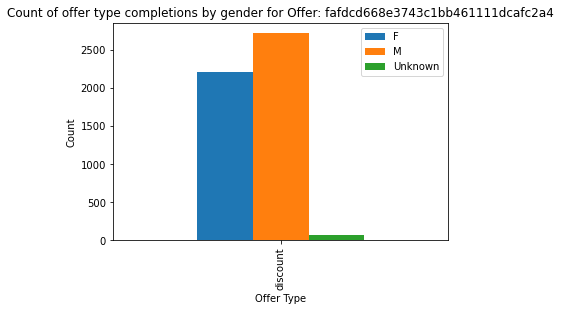

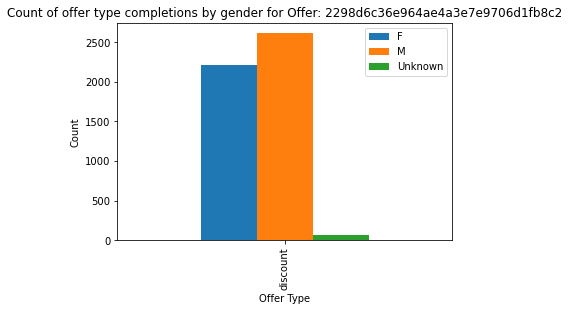

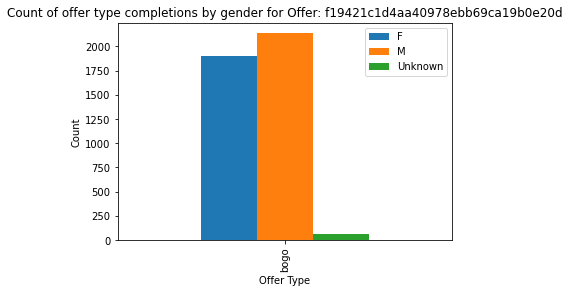

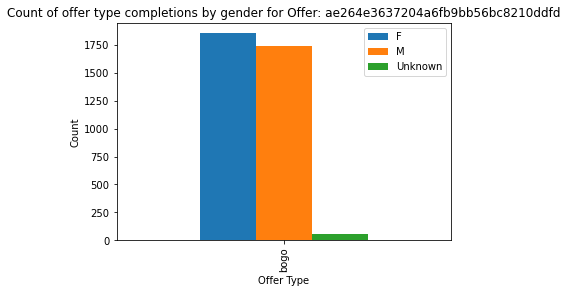

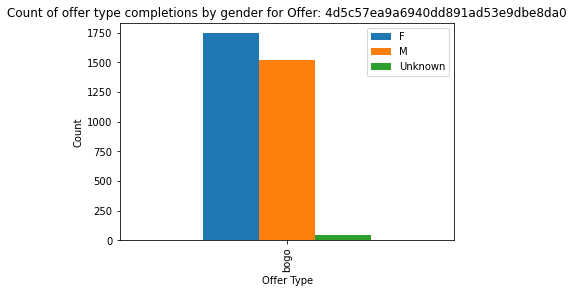

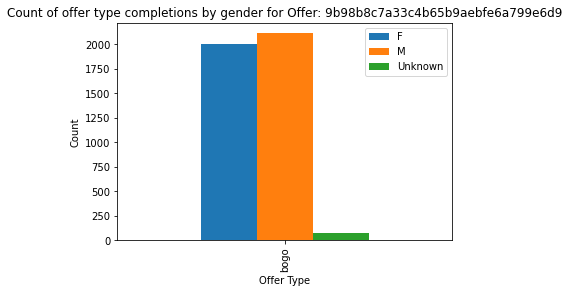

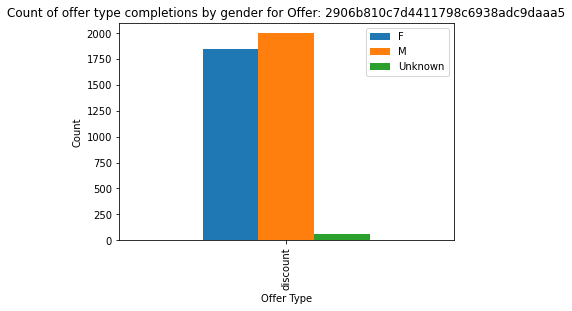

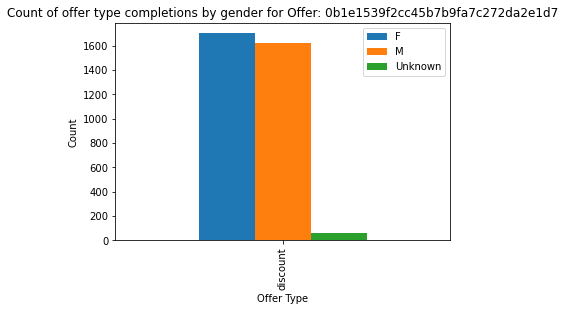

In [156]:
# Iterate through unique offers and input them into function above to obtain visualizations
for offer_num in offer_list:
    offer_completion_gender(offer_str = offer_num)

In [96]:
# Creating ml table for write up
data2 = {'Model':['No Scaling/Normalization','Normalization','Standardization'],
        'r-squared Value':['5.88%','5.88%','5.88%']}
results_df = pd.DataFrame(data2)
dfi.export(results_df,'ml_results_table.png')

In [97]:
# Creating table for write up on common columns
data = {'Data Set':['portfolio.json','offers.json','transcript.json'],
       'Common Column':['Customer ID','Offer ID', 'Customer ID & Offer ID']}
common_col = pd.DataFrame(data)
dfi.export(common_col, 'Common_Columns.png')